In [1]:
import numpy as np
import matplot lib.pyplot as plt
from scipy.integrate import odeint

import os
import random
from sklearn.model_selection import train_test_split

The next cell defines the `pend` function that contains the system of nonlinear differential equations representing the pendulum dynamics.

In [2]:
def pend(x, t, u, b, c):
    x1, x2 = x
    dxdt = [x2, -b*x2 - c*np.sin(x1) + u]
    return dxdt

In the cell below, the parameters of the pendulum dynamics, the initial condition vector and the time vector are defined. 

In [3]:
def generate_data_IO(t, n_instances, n_states, b, c):
    '''
    
    INPUTS:
    - 
    - 
    - kwargs: parameters of the system
    
    OUTPUTS:
    -
    -
    
    '''

    # Creating containers for the inputs and the outputs (i.e., random inputs and states) given a number of instances
    Y = np.zeros(shape = (n_instances, t.shape[0], n_states))

    # Container for inputs to the NN
    X = np.zeros(shape = (n_instances, t.shape[0], n_states))

    for n_inst in range(n_instances):

        u = np.random.rand(t.shape[0], )

        #x0 = [np.pi - 0.1, 0.0]
        x0 = np.random.rand(n_states, )

        X[n_inst, 0, :] = x0
        Y[0, 0, :] = x0

        for k in range(len(t) - 1):

            # Integration time
            t_int = np.linspace(t[k], t[k+1], 200)

            # Integration
            x_int = odeint(pend, x0, t_int, args = (u[k], b, c))

            # Extracting the outputs
            for state in range(x_int.shape[-1]):
                Y[n_inst, k+1, state] = x_int[-1, state]

            # Updating initial condition for next integration
            x0 = x_int[-1, :]

        # Storing input in container for NN input
        X[n_inst, 1:, 0] = u[:k+1]
    
    return X, Y

t = np.linspace(0, 20, 500)

X, Y = generate_data_IO(t = t, n_instances = 1000, n_states = 2, b = 0.25, c = 5.00)
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

X: (1000, 500, 2)
Y: (1000, 500, 2)


The output is visualized extracting the states from each column of the output matrix from the integration step

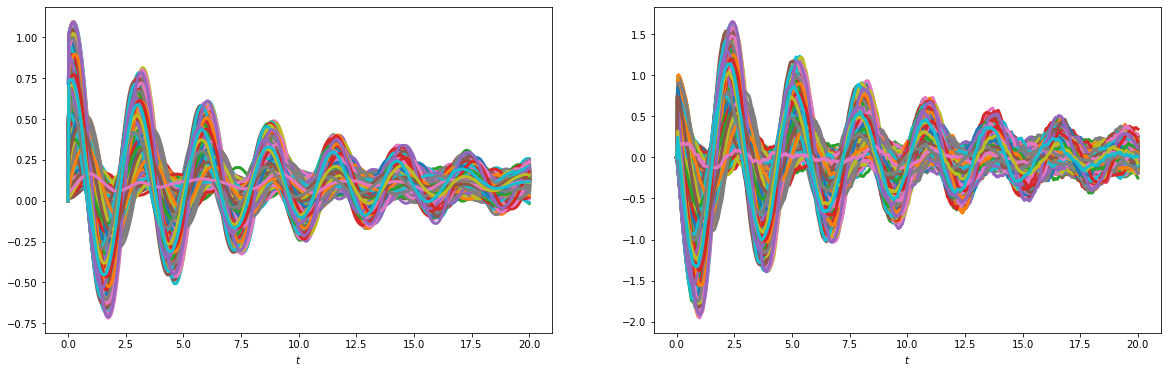

In [4]:
fig, axes = plt.subplots(figsize = (20, 6), nrows = 1, ncols = 2)

for inst in range(X.shape[0]):

    axes[0].plot(t, Y[inst, :, 0], label = "$x_1(t)$", linewidth = 3)
    axes[1].plot(t, Y[inst, :, 1], label = "$x_2(t)$", linewidth = 3)

#axes[0].legend(loc = "best")
#axes[1].legend(loc = "best")
axes[0].set_xlabel("$t$")
axes[1].set_xlabel("$t$");

In [5]:
n_instances = X.shape[0]
n_validation = int(0.1*X.shape[0])
ind_validation = random.sample(range(0, n_instances), n_validation)

X_valid = X[ind_validation, :, :]
Y_valid = Y[ind_validation, :, :]

X_all = np.delete(X, ind_validation, axis = 0)
Y_all = np.delete(Y, ind_validation, axis = 0)

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 42)

print(f"X_train: {X_train.shape} - Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} - Y_test: {Y_test.shape}")
print(f"X_valid: {X_valid.shape} - Y_valid: {Y_valid.shape}")

X_train: (720, 500, 2) - Y_train: (720, 500, 2)
X_test: (180, 500, 2) - Y_test: (180, 500, 2)
X_valid: (100, 500, 2) - Y_valid: (100, 500, 2)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(LSTM(200,
               input_shape = (X_train.shape[1], X_train.shape[2]),
               return_sequences = True))
model.add(TimeDistributed(Dense(2)))
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 200)          162400    
_________________________________________________________________
time_distributed (TimeDistri (None, 500, 2)            402       
Total params: 162,802
Trainable params: 162,802
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_dir = os.path.abspath('sysid_test_lstm')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

filepath = os.path.join(model_dir, 'LSTM_Model_SysID.hdf5') 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only = True, mode = 'min', patience = 10)
callbacks = [checkpoint]

hist = model.fit(X_train, Y_train, 
                 epochs = 200, batch_size = 100, 
                 callbacks = callbacks, 
                 validation_data = (X_valid, Y_valid),
                 verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 720 samples, validate on 100 samples
Epoch 1/200
700/720 [============================>.] - ETA: 0s - loss: 0.0917 - mean_squared_error: 0.0917
Epoch 00001: val_loss improved from inf to 0.08994, saving model to /data/home/dorads/Documents/GitHub_Repositories/01_Maintained/NeuralODE/test/nonlinear_system_test/sysid_test_lstm/LSTM_Model_SysID.hdf5
720/720 [==============================] - 5s 6ms/sample - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0899 - val_mean_squared_error: 0.0899
Epoch 2/200
700/720 [============================>.] - ETA: 0s - loss: 0.0891 - mean_squared_error: 0.0891
Epoch 00002: val_loss improved from 0.08994 to 0.08922, saving model to /data/home/dorads/Documents/GitHub_Repositories/01_Maintained/NeuralODE/test/nonlinear_system_test/sysid_test_lstm/LSTM_Model_SysID.hdf5
720/720 [==============================] - 4s 5ms/sample - loss: 0.0894 - mean_

In [ ]:
# load the model with the smallest validation loss
model.load_weights(filepath)

# use the test data to predict the model response
Y_predict = model.predict(X_test)

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss)+1)

NameError: name 'Y_test' is not defined

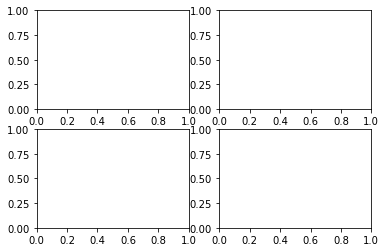

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)

axes[0][0].plot(t, Y_test[1, :, 0], label = "Ground Truth")
axes[0][0].plot(t, Y_predict[1,:,0], label = "Prediction")

# State 2
axes[0][1].plot(t, Y_test[1, :, 1], label = "Ground Truth")
axes[0][1].plot(t, Y_predict[1,:,1], label = "Prediction")

# Loss function
axes[1][0].plot(epochs, loss, label = "Loss")
axes[1][1].plot(epochs, val_loss, label = "Validation Loss")